In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lifelines import KaplanMeierFitter
import numpy as np
from sklearn.utils import resample
from lifelines import WeibullFitter
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored

In [2]:
df = pd.read_csv("Regn2004-2025.csv", sep=";")
df['Dato'] = pd.to_datetime(df['Dato'], format='%d.%m.%Y')
df_temp = pd.read_csv("Temperatur 2004-2025.csv", sep=";")
df_temp['Dato'] = pd.to_datetime(df_temp['Dato'], format='%d.%m.%Y')
df = df.merge(df_temp, on=['Dato', 'Tid'], how='left')

df['Tid'] = df.apply(lambda x: int(x['Tid'].split(':')[0]), axis=1)
df['datetime'] = df['Dato'] + pd.to_timedelta(df['Tid'], unit='h')

In [41]:
absorbtions = {'clay': 0.1, 'sand': 0.1, 'silt': 0.1, 'peat': 0.1, 'loam': 0.1}

for soil_type in absorbtions.keys():
    df[f'WOG_{soil_type}'] = 0.0
    
    # Apply cumulative calculation using expanding window
    for soil_type, rate in absorbtions.items():
        # Create temporary series for calculation
        wog = pd.Series(0.0, index=df.index)
        
        # Loop is necessary because each calculation depends on previous result
        for i in range(1, len(df)):
            wog.iloc[i] = max(0, wog.iloc[i-1] * (1 - rate) + df['Nedbor'].iloc[i])
            
        # Assign back to dataframe
        df[f'WOG_{soil_type}'] = wog

df.dropna(inplace=True)

In [42]:
# Label dry spells (0 = dry, 1 = rain)
df["is_rain"] = (df["WOG_clay"] > 10).astype(int)

In [43]:
# lav en water at ground kollone og brug den (jordtype)

In [44]:
# Compute durations of dry spells
dry_spells = []
current_duration = 0
censored = False  # True if the last dry spell was ongoing at the end of the dataset
durations = []

for idx, row in df.iterrows():
    if row["is_rain"] == 0:
        current_duration += 1
    else:
        if current_duration > 0:
            dry_spells.append({"duration": current_duration, "observed": 1})
            current_duration = 0
    durations.append(current_duration)
# Handle censoring (if the dataset ends with a dry spell)
if current_duration > 0:
    dry_spells.append({"duration": current_duration, "observed": 0})

# Convert to DataFrame
dry_spell_df = pd.DataFrame(dry_spells)

df['duration'] = durations

In [45]:
df['is_rain'].value_counts()

is_rain
0    210809
1      1239
Name: count, dtype: int64

Text(0, 0.5, 'Frequency')

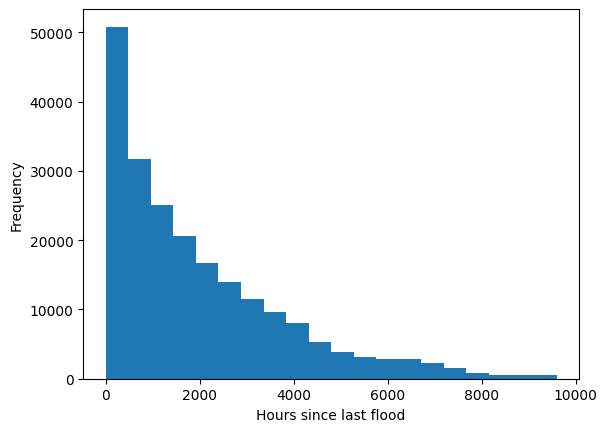

In [46]:
plt.hist(durations, bins=20)
plt.xlabel("Hours since last flood")
plt.ylabel("Frequency")

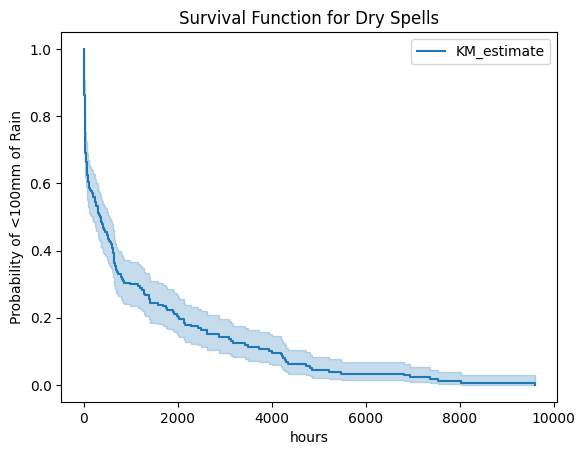

In [47]:
kmf = KaplanMeierFitter()
kmf.fit(durations=dry_spell_df["duration"], event_observed=dry_spell_df["observed"])

# Plot survival function with 95% confidence intervals
import matplotlib.pyplot as plt

kmf.plot_survival_function()
plt.title("Survival Function for Dry Spells")
plt.xlabel("hours")
plt.ylabel("Probability of <100mm of Rain")
plt.show()

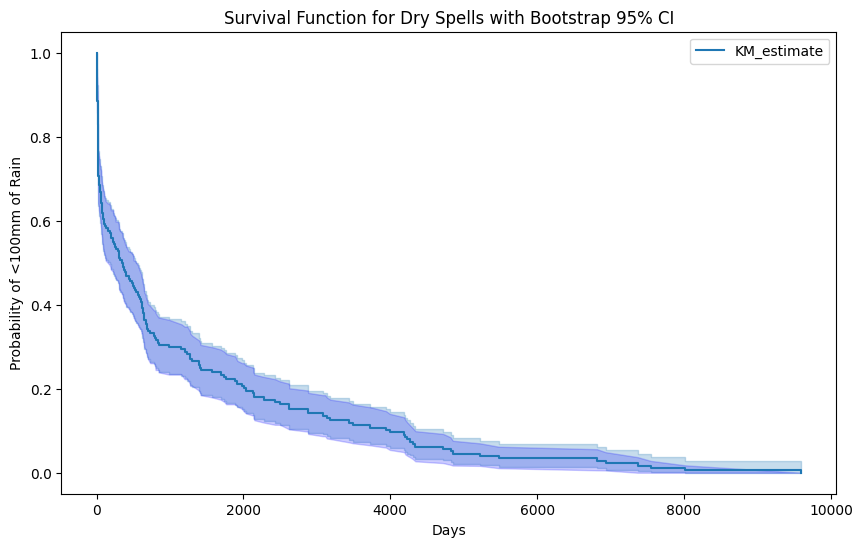

In [48]:
# First define a consistent timeline for all bootstrap samples
timeline = np.unique(dry_spell_df["duration"])  # Or use a predefined range

# Create empty list to store bootstrap results
bootstrap_estimates = []

# Run bootstrap
n_bootstraps = 1000
for i in range(n_bootstraps):
    # Sample with replacement
    bootstrap_sample = dry_spell_df.sample(n=len(dry_spell_df), replace=True)
    
    # Fit KM model
    kmf_boot = KaplanMeierFitter()
    kmf_boot.fit(durations=bootstrap_sample["duration"], 
                 event_observed=bootstrap_sample["observed"])
    
    # Get survival function at consistent timeline points
    survival_at_times = kmf_boot.survival_function_at_times(timeline)
    bootstrap_estimates.append(survival_at_times)

# Convert to numpy array (now all samples have same shape)
bootstrap_array = np.array(bootstrap_estimates)

# Compute 95% confidence intervals
lower_bound = np.percentile(bootstrap_array, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_array, 97.5, axis=0)

# Plot original curve with bootstrap confidence intervals
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()

# Add bootstrap confidence intervals
plt.fill_between(timeline, lower_bound, upper_bound, alpha=0.2, color='blue')

plt.title("Survival Function for Dry Spells with Bootstrap 95% CI")
plt.xlabel("Days")
plt.ylabel("Probability of <100mm of Rain")
plt.show()

             coef  se(coef)  coef lower 95%  coef upper 95%  cmp to         z  \
lambda_  1.137556  0.048609        1.042285        1.232827     1.0  2.829871   
rho_     3.862826  0.359584        3.158054        4.567598     1.0  7.961493   

                    p   -log2(p)  
lambda_  4.656684e-03   7.746481  
rho_     1.699763e-15  49.063588  


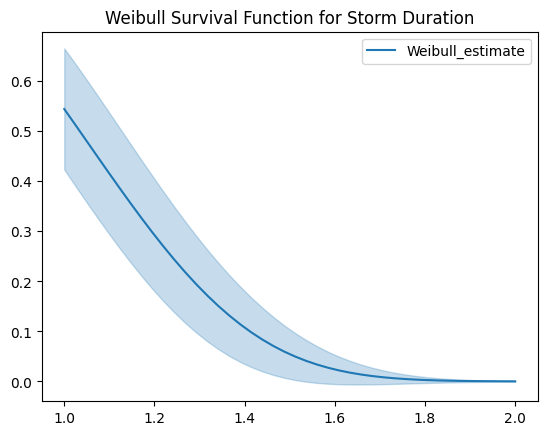

In [26]:
# Preprocess storm durations (similar to dry spells but for rain events)
storm_durations = []
current_duration = 0
censored = False

for idx, row in df.iterrows():
    if row["is_rain"] == 1:
        current_duration += 1
    else:
        if current_duration > 0:
            storm_durations.append({"duration": current_duration, "observed": 1})
            current_duration = 0
if current_duration > 0:
    storm_durations.append({"duration": current_duration, "observed": 0})

# Convert list of dictionaries to DataFrame
storm_df = pd.DataFrame(storm_durations)

# Now fit the Weibull model with proper data format
wf = WeibullFitter()
wf.fit(durations=storm_df["duration"], event_observed=storm_df["observed"])

print(wf.summary)  # Parameters (lambda, rho) with confidence intervals
wf.plot_survival_function()
plt.title("Weibull Survival Function for Storm Duration")
plt.show()

In [ ]:
# from lifelines import AalenAdditiveFitter
# Bayesian Deep Survival Models
# Spatial Survival
# from lifelines import CoxPHFitter

In [ ]:
# Aggregate data to daily level
daily_df = df.groupby("Dato")["Nedbor"].sum().reset_index()
daily_df["is_rain"] = (daily_df["Nedbor"] > 5).astype(int)

In [34]:
daily_df[daily_df['Nedbor'] >= 30].value_counts().sum()

np.int64(52)

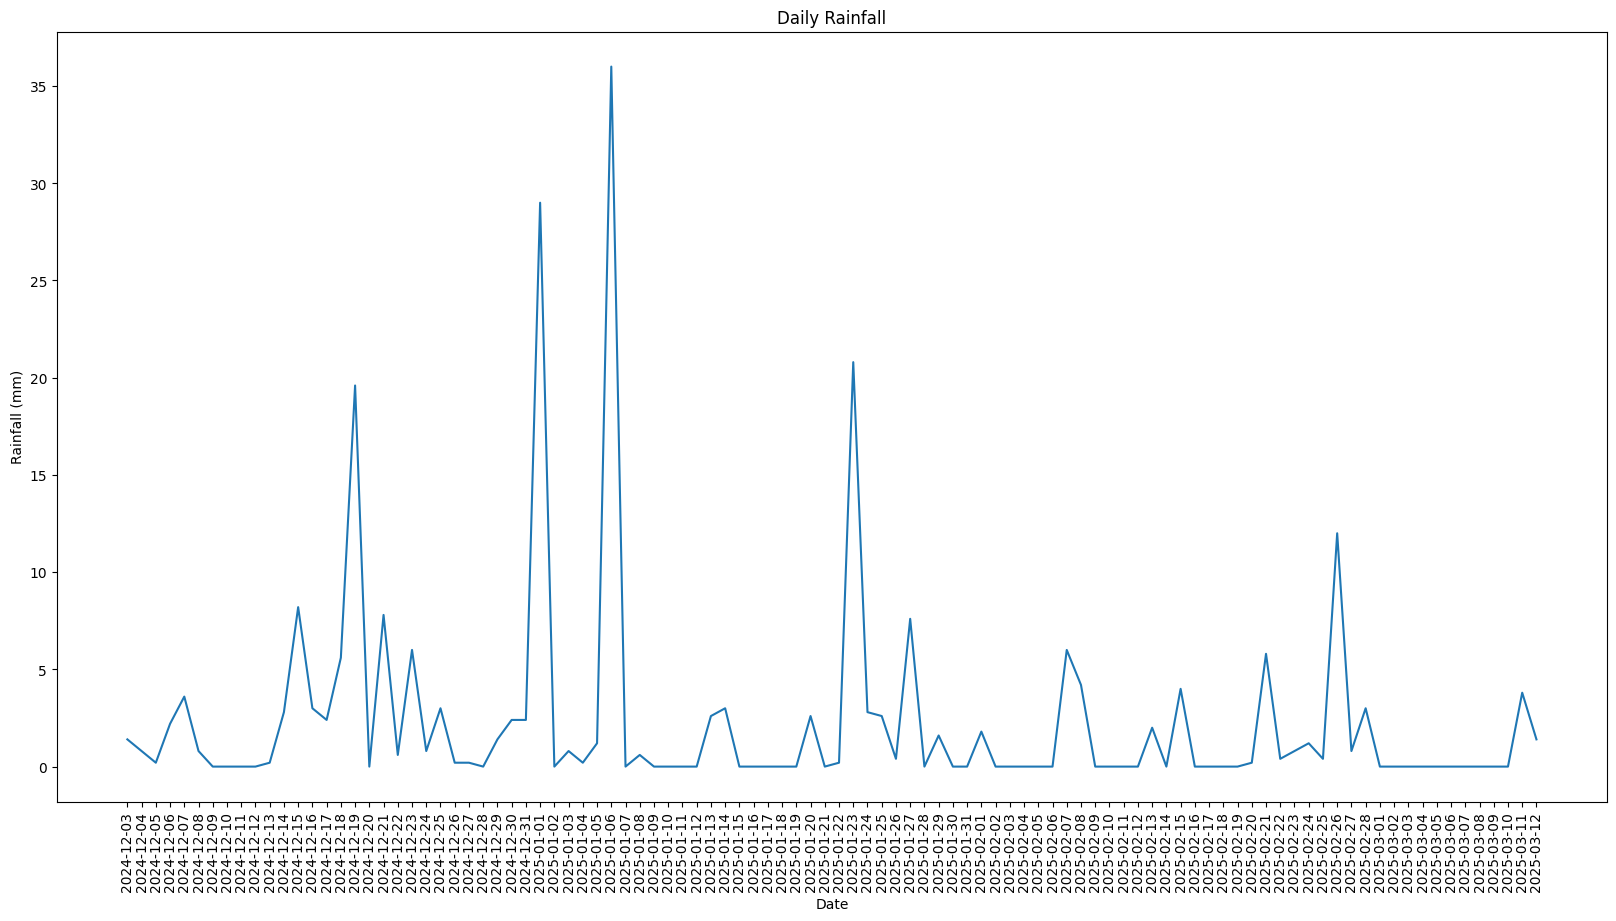

In [29]:
# make a scatter plot of the data with small dots and only for the last 100 days
plt.figure(figsize=(20, 10))
#plt.scatter(daily_df["Dato"][-100:], daily_df["Nedbor"][-100:], s=5)
plt.plot(daily_df["Dato"][-100:], daily_df["Nedbor"][-100:])

plt.title("Daily Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=90)
plt.show()

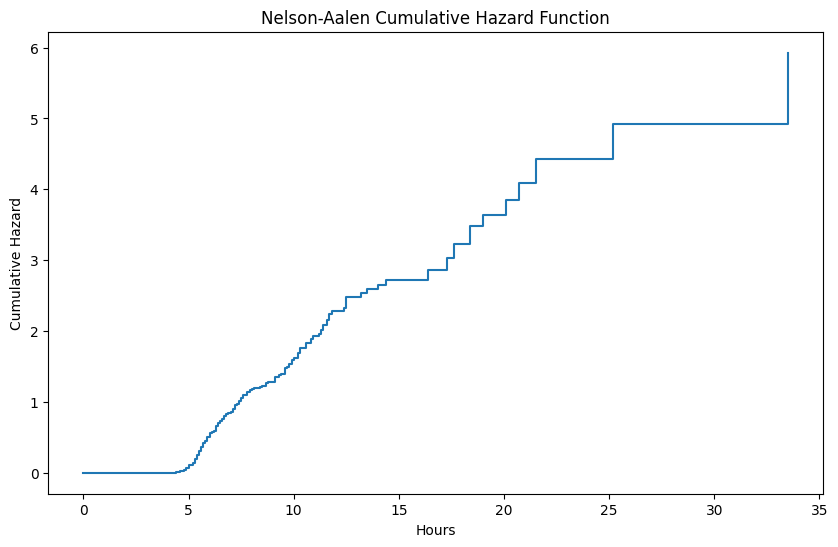

In [8]:
from sksurv.nonparametric import nelson_aalen_estimator

# Compute Nelson-Aalen estimator
na_estimator = nelson_aalen_estimator(df["is_rain"].astype(bool), df["Nedbor"])

# Plot cumulative hazard function
plt.figure(figsize=(10, 6))
plt.step(na_estimator[0], na_estimator[1], where="post")
plt.title("Nelson-Aalen Cumulative Hazard Function")
plt.xlabel("Hours")
plt.ylabel("Cumulative Hazard")
plt.show()


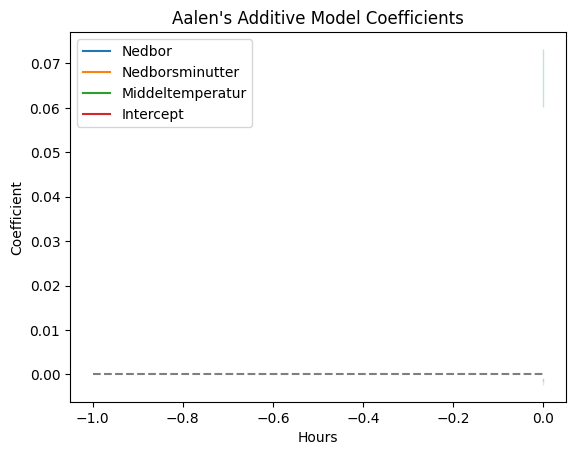

In [17]:
from lifelines import AalenAdditiveFitter

# Fit Aalen's Additive model
aaf = AalenAdditiveFitter()
aaf.fit(df[['Nedbor','Nedborsminutter','Middeltemperatur','duration','is_rain']], "duration", event_col="is_rain")

# Plot the estimated coefficients
aaf.plot()
plt.title("Aalen's Additive Model Coefficients")
plt.xlabel("Hours")
plt.ylabel("Coefficient")
plt.show()


In [7]:
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler

y = Surv.from_arrays(event=df['is_rain'], time=df['datetime'])
X = df[['Nedbor','Nedborsminutter','Middeltemperatur','duration']]
event = df['is_rain']
time = df['datetime']

# 1. Check for issues in your data
print("X contains NaN:", np.isnan(X).any())
print("X contains inf:", np.isinf(X).any())
print("Event distribution:", np.bincount(event))
print("Time range:", time.min(), "to", time.max())

# 2. Standardize features to improve numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Create the structured array with proper data types
y = Surv.from_arrays(event=event, time=time)


X contains NaN: Nedbor              False
Nedborsminutter     False
Middeltemperatur    False
duration            False
dtype: bool
X contains inf: Nedbor              False
Nedborsminutter     False
Middeltemperatur    False
duration            False
dtype: bool
Event distribution: [211816    232]
Time range: 2004-01-01 01:00:00 to 2025-03-12 17:00:00


In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

# 4. Add regularization to help with potential singularity
cph = CoxPHSurvivalAnalysis(alpha=0.1)  # L2 regularization
cph.fit(X_scaled, y)  # Use scaled features

# 5. Predict risk scores
risk_scores = cph.predict(X_scaled)


X contains NaN: Nedbor              False
Nedborsminutter     False
Middeltemperatur    False
duration            False
dtype: bool
X contains inf: Nedbor              False
Nedborsminutter     False
Middeltemperatur    False
duration            False
dtype: bool
Event distribution: [211816    232]
Time range: 2004-01-01 01:00:00 to 2025-03-12 17:00:00


/home/rasmus/Desktop/School Local/42578 Advanced Business Analytics/aba_flooding/.venv/lib/python3.12/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/home/rasmus/Desktop/School Local/42578 Advanced Business Analytics/aba_flooding/.venv/lib/python3.12/site-packages/sksurv/linear_model/coxph.py:470: RuntimeWarning: invalid value encountered in scalar divide
  res = np.abs(1 - (loss_new / loss))
/home/rasmus/Desktop/School Local/42578 Advanced Business Analytics/aba_flooding/.venv/lib/python3.12/site-packages/sksurv/linear_model/coxph.py:194: RuntimeWarning: overflow encountered in exp
  exp_xw = np.exp(offset + np.dot(x, w))
/home/rasmus/Desktop/School Local/42578 Advanced Business Analytics/aba_flooding/.venv/lib/python3.12/site-packages/sksurv/linear_model/coxph.py:238: RuntimeWarning: invalid value encountered in divide
  z = risk_set_x / risk_set
/home/rasmus/Desktop/School Local/42578 Advanced Business Analyti

ValueError: LAPACK reported an illegal value in 5-th argument.

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

# Random Survival Forest tends to be more robust to data issues
rsf = RandomSurvivalForest(n_estimators=100, 
                          min_samples_split=10,
                          min_samples_leaf=15,
                          random_state=42)
rsf.fit(X, y)

In [ ]:
plt.figure(figsize=(10, 6))
plt.step(rsf.event_times_, rsf.predict_survival_function(X.iloc[0:1]).flatten(), where="post")
plt.title("Survival Function for Random Survival Forest")
plt.xlabel("Hours")
plt.ylabel("Survival Probability")
plt.show()

In [10]:
# Support vector machine for survival analysis
from sksurv.svm import FastSurvivalSVM

# Fit the model
fsvm = FastSurvivalSVM(optimizer="rbtree")
fsvm.fit(X, y)

# Predict risk scores
risk_scores_svm = fsvm.predict(X)

# Evaluate performance
conc_index = concordance_index_censored(event.astype(bool), time, risk_scores_svm)
print("C-index:", conc_index[0])

# Plot the survival function (corrected approach)
plt.figure(figsize=(10, 6))

# Get sorted unique time points from your data
# Assuming 'time' contains your time values
unique_times = np.sort(np.unique(time))

# Predict survival function for a sample
survival_func = fsvm.predict_survival_function(X.iloc[0:1])

# Plot the survival curve
plt.step(unique_times, survival_func(unique_times), where="post")
plt.title("Survival Function for Fast Survival SVM")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

/tmp/ipykernel_735/635195362.py:6: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  fsvm.fit(X, y)


C-index: 0.9995986542076266


AttributeError: 'FastSurvivalSVM' object has no attribute 'predict_survival_function'

<Figure size 1000x600 with 0 Axes>

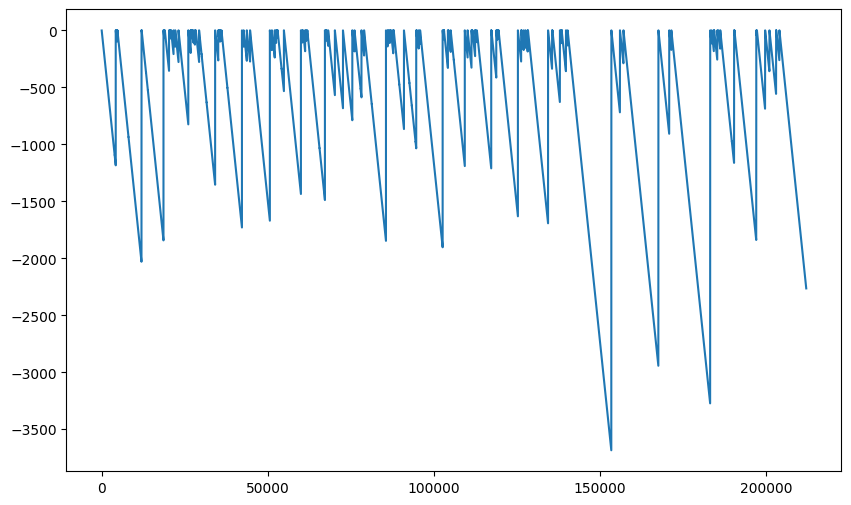

In [14]:
fsvm.predict(X.iloc[0:20000])

plt.figure(figsize=(10, 6))
plt.plot(fsvm.predict(X).flatten())